In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
qml.drawer.use_style('sketch')

In [3]:
class ReOrIm(Enum):
    real = 0
    imag = 1

In [4]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def hadamard_test_circuit(theta, phi, re_or_im=ReOrIm.real):
    # Prepare the superposition state |psi> = (|0>|a> + |1>|b>)/sqrt(2)
    # 1. Apply the Hadamard gate to the first qubit
    qml.Hadamard(wires=0)

    # 2. Apply S^dagger to the first qubit if we are measuring the imaginary part
    if re_or_im == ReOrIm.imag:
        qml.adjoint(qml.S)(wires=0)
        
    # 3. Apply the controlled unitary U where U|0> = |a> and U|1> = |b>
    qml.RY(2 * theta, wires=1) # |a> = Ry(theta)|0>
    qml.CRY(2 * (phi-theta), wires=[0, 1])

    # 4. Apply the Hadamard gate to the first qubit
    qml.Hadamard(wires=0)
    return qml.probs(wires=0)

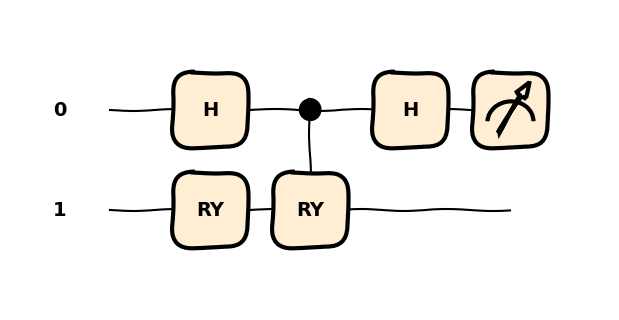

In [5]:
qml.draw_mpl(hadamard_test_circuit)(np.pi/4, np.pi/3)
plt.show()

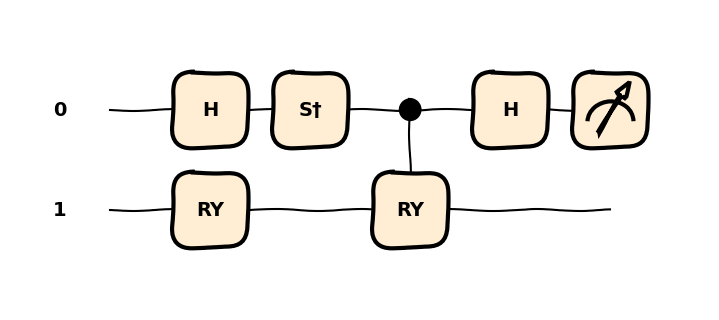

In [6]:
qml.draw_mpl(hadamard_test_circuit)(np.pi/4, np.pi/3, re_or_im=ReOrIm.imag)
plt.show()

**Explanation of the circuit**

Assume $|a\rangle = R_y(2\theta)|0\rangle$ and $|b\rangle = R_y(2\phi)|0\rangle$.

1) Apply Hadamard gate to first qubit (0) to create superposition
$$
H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$$

2) Apply RY gate to second qubit (1) with angle $2\theta$ to create state $|a\rangle$
$$
|a\rangle = R_y(2\theta)|0\rangle
$$

3) Apply CRY gate to first qubit (0) and second qubit (1) with angle $2(\phi-\theta)$ to create state $|b\rangle$
$$
\begin{aligned}
|\psi\rangle &= CR_y(2(\phi-\theta))\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)|a\rangle \\
&= \frac{1}{\sqrt{2}}(|0\rangle|a\rangle + |1\rangle R_y (2(\phi-\theta))|a\rangle) \\
&= \frac{1}{\sqrt{2}}(|0\rangle|a\rangle + |1\rangle R_y(2\phi)|0\rangle) \\
&= \frac{1}{\sqrt{2}}(|0\rangle|a\rangle + |1\rangle|b\rangle)
\end{aligned}
$$

4) Apply Hadamard gate to first qubit (0) again
$$
\begin{aligned}
H|\psi\rangle &= \frac{1}{\sqrt{2}}(H|0\rangle|a\rangle + H|1\rangle|b\rangle) \\
&= \frac{1}{2}(|0\rangle|a\rangle + |0\rangle|b\rangle + |1\rangle|a\rangle - |1\rangle|b\rangle) \\
&= \frac{1}{2}(|0\rangle(|a\rangle + |b\rangle) + |1\rangle(|a\rangle - |b\rangle))
\end{aligned}
$$

5) Measure first qubit (0).
$$
P(|x\rangle = |0\rangle) = \frac{1}{4}(|a\rangle + |b\rangle)^2 = \frac{1}{2}(1 + \text{Re}(\langle a|b\rangle))
$$

For imaginary part of $\langle a|b\rangle$, we add $S^\dagger$ gate to the ancilla qubit after step 1.

$$
S^\dagger H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle - i|1\rangle) 
$$

Then repeat step 2 to 5.

$$
P(|x\rangle = |0\rangle) = \frac{1}{4}(|a\rangle - i|b\rangle)^2 = \frac{1}{2}(1 - \text{Im}(\langle a|b\rangle))
$$

For example, let's obtain $\langle a | b \rangle$ for $\theta = \pi/4$ and $\phi = \pi/3$.

$$
\begin{aligned}
|a\rangle &= R_y(2\times\frac{\pi}{4})|0\rangle = \frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle \\
|b\rangle &= R_y(2\times\frac{\pi}{3})|0\rangle = \frac{1}{2}|0\rangle + \frac{\sqrt{3}}{2}|1\rangle \\
\langle a | b \rangle &= \frac{1}{2\sqrt{2}} + \frac{\sqrt{3}}{2\sqrt{2}} \simeq 0.9659
\end{aligned}
$$

In [7]:
p_0_real = hadamard_test_circuit(np.pi/4, np.pi/3, re_or_im=ReOrIm.real)[0]
p_0_imag = hadamard_test_circuit(np.pi/4, np.pi/3, re_or_im=ReOrIm.imag)[0]

print(f"Probability of measuring |0> when measuring the real part: {p_0_real:.4f}")
print(f"Probability of measuring |0> when measuring the imaginary part: {p_0_imag:.4f}")

inner_prod_real = 2 * p_0_real - 1
inner_prod_imag = 1 - 2 * p_0_imag

print(f"Real part of the inner product: {inner_prod_real:.4f}")
print(f"Imaginary part of the inner product: {inner_prod_imag:.4f}")

# The inner product of the two states is the sum of the real and imaginary parts
inner_prod = inner_prod_real + 1j * inner_prod_imag
print(f"Inner product of the two states: {inner_prod:.4f}")

Probability of measuring |0> when measuring the real part: 0.9830
Probability of measuring |0> when measuring the imaginary part: 0.5000
Real part of the inner product: 0.9659
Imaginary part of the inner product: 0.0000
Inner product of the two states: 0.9659+0.0000j
